In [2]:

import itertools
import math
from collections import OrderedDict, Counter
from dataclasses import dataclass
from typing import Dict, Optional, Sequence, Tuple, List
from typing import Iterable

import matplotlib.pyplot as plt
import networkx as nx
import torch
from pytorch_lightning import seed_everything
from rdkit import Chem
from torch_geometric.loader import DataLoader
from torch_geometric.data import Data
from torchhd import HRRTensor

from src.datasets.zinc_pairs import pyg_to_nx
from src.datasets.zinc_smiles_generation import ZincSmiles
from src.encoding.configs_and_constants import DatasetConfig, Features, FeatureConfig, IndexRange
from src.encoding.feature_encoders import CombinatoricIntegerEncoder
from src.encoding.graph_encoders import HyperNet, load_or_create_hypernet
from src.encoding.oracles import Oracle
from src.encoding.the_types import VSAModel
from src.utils.utils import GLOBAL_MODEL_PATH

"""
Features
    Atom types size: 9
    Atom types: ['Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S']
    Degrees size: 5, encoded with 0 index:
    Degrees: {1, 2, 3, 4, 5}
    Formal Charges size: 3
    Formal Charges: {0, 1, -1}
    Explicit Hs size: 4
    Explicit Hs: {0, 1, 2, 3}
Encodings:
    float(ZINC_SMILE_ATOM_TO_IDX[atom.GetSymbol()]),
    float(atom.GetDegree() - 1),  # [1, 2, 3, 4, 5] -> [0, 1, 2, 3, 4]
    float(atom.GetFormalCharge() if atom.GetFormalCharge() >= 0 else 2),  # [0, 1, -1] -> [0, 1, 2]
    float(atom.GetTotalNumHs()),
"""

"\nFeatures\n    Atom types size: 9\n    Atom types: ['Br', 'C', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S']\n    Degrees size: 5, encoded with 0 index:\n    Degrees: {1, 2, 3, 4, 5}\n    Formal Charges size: 3\n    Formal Charges: {0, 1, -1}\n    Explicit Hs size: 4\n    Explicit Hs: {0, 1, 2, 3}\nEncodings:\n    float(ZINC_SMILE_ATOM_TO_IDX[atom.GetSymbol()]),\n    float(atom.GetDegree() - 1),  # [1, 2, 3, 4, 5] -> [0, 1, 2, 3, 4]\n    float(atom.GetFormalCharge() if atom.GetFormalCharge() >= 0 else 2),  # [0, 1, -1] -> [0, 1, 2]\n    float(atom.GetTotalNumHs()),\n"

In [3]:
seed = 42

seed_everything(seed)
device = torch.device('cpu')
# ----- hypernet config (kept for provenance; not needed in this flow) -----
ds_name = "ZincSmilesHRR7744"
zinc_feature_bins = [9, 6, 3, 4]
dataset_config = DatasetConfig(
    seed=42,
    name=ds_name,
    vsa=VSAModel.HRR,
    hv_dim=88 * 88,
    device=device,
    node_feature_configs=OrderedDict(
        [
            (

                Features.ATOM_TYPE,
                FeatureConfig(
                    count=math.prod(zinc_feature_bins),
                    encoder_cls=CombinatoricIntegerEncoder,
                    index_range=IndexRange((0, 4)),
                    bins=zinc_feature_bins,
                ),
            ),
        ]
    ),
)

print("Loading/creating hypernet …")
hypernet: HyperNet = (
    load_or_create_hypernet(path=GLOBAL_MODEL_PATH, cfg=dataset_config).to(device=device)
)
print("Hypernet ready.")
assert not hypernet.use_edge_features()
assert not hypernet.use_graph_features()



Seed set to 42


Loading/creating hypernet …
Loading existing HyperNet from /Users/akaveh/projects/kit/graph_hdc/_models/hypernet_ZincSmilesHRR7744_HRR_dim7744_s42_depth3_ecb0.pt
Hypernet ready.


Classifier's cfg
{   'batch_size': 256,
    'continue_from': None,
    'epochs': 20,
    'exclude_negs': [],
    'exp_dir_name': 'mlp_stratified_base_laynorm_2nd_try',
    'hidden_dims': [4096, 2048, 512, 128],
    'hv_dim': 7744,
    'hv_scale': None,
    'keep_last_k': 2,
    'lr': 0.0001,
    'micro_bs': 64,
    'n_per_parent': 25,
    'num_workers': 0,
    'oracle_beam_size': 32,
    'oracle_num_evals': 32,
    'p_per_parent': 25,
    'pin_memory': False,
    'prefetch_factor': 1,
    'project_dir': PosixPath('/home/iti/zi9629/graph_hdc'),
    'resample_training_data_on_batch': True,
    'resume_retrain_last_epoch': False,
    'save_every_seconds': 3600,
    'seed': 42,
    'stratify': True,
    'train_parents_end': None,
    'train_parents_start': None,
    'use_batch_norm': False,
    'use_layer_norm': True,
    'valid_parents_end': None,
    'valid_parents_start': None,
    'vsa': <VSAModel.HRR: 'HRR'>,
    'weight_decay': 0.0}
[2025-09-08 09:42:57] Using Layer Normalization: Tr

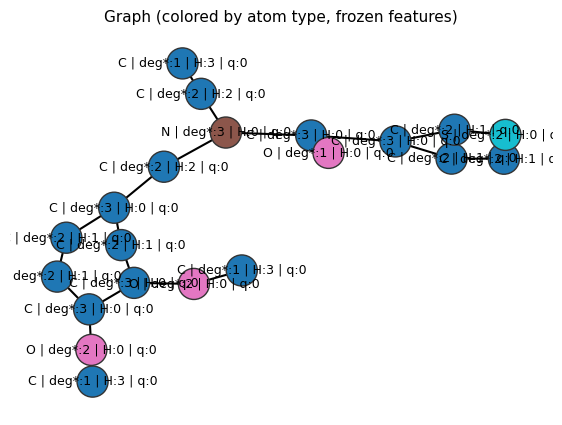

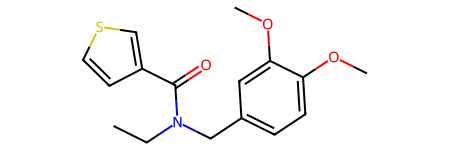

Num Nodes 21
Num Edges 22
Multiset Nodes 21
Decoding a graph with 21 nodes and 22 edges.
0
[]
[1] Original Graph


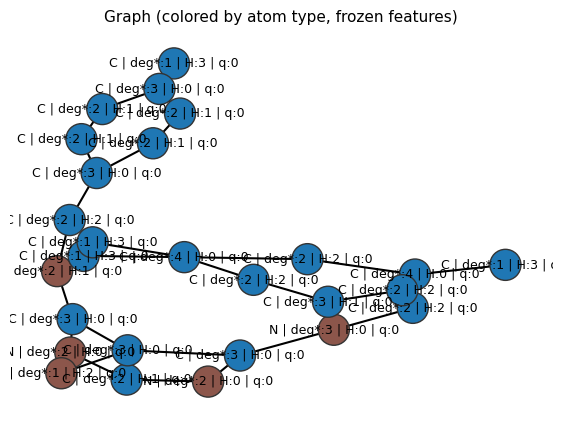

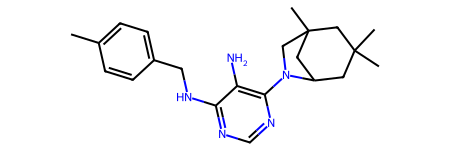

Num Nodes 27
Num Edges 30
Multiset Nodes 27
Decoding a graph with 27 nodes and 30 edges.
0
[]
[2] Original Graph


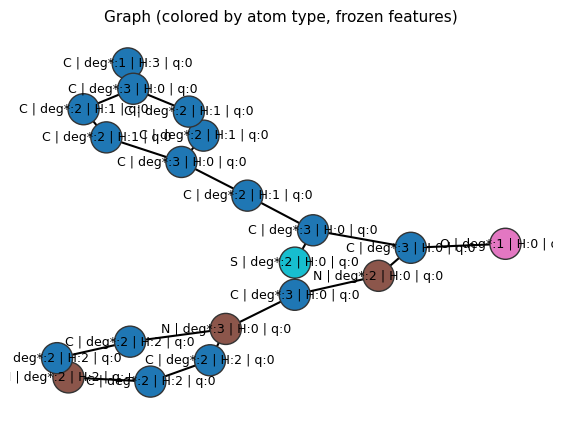

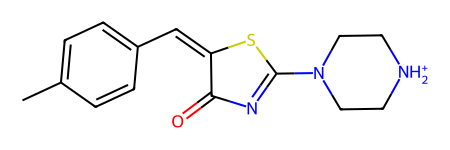

Num Nodes 20
Num Edges 22
Multiset Nodes 20
Decoding a graph with 20 nodes and 22 edges.
0
[]
[3] Original Graph


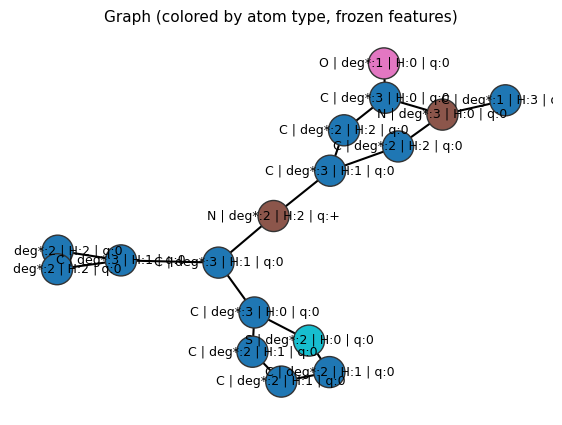

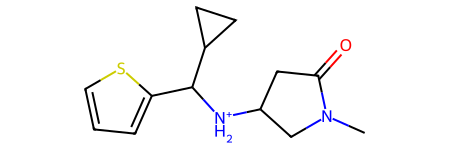

Num Nodes 17
Num Edges 19
Multiset Nodes 17
Decoding a graph with 17 nodes and 19 edges.
11
[<networkx.classes.graph.Graph object at 0x4d1c6c170>, <networkx.classes.graph.Graph object at 0x4d1c81640>, <networkx.classes.graph.Graph object at 0x4d1c82f90>, <networkx.classes.graph.Graph object at 0x4d1c83890>, <networkx.classes.graph.Graph object at 0x4d1c83ec0>, <networkx.classes.graph.Graph object at 0x4d1c81760>, <networkx.classes.graph.Graph object at 0x4d1c6c680>, <networkx.classes.graph.Graph object at 0x4d1c6eb10>, <networkx.classes.graph.Graph object at 0x4d1c6df40>, <networkx.classes.graph.Graph object at 0x469e204d0>, <networkx.classes.graph.Graph object at 0x4d1c6fbf0>]
Graph Nr: 0


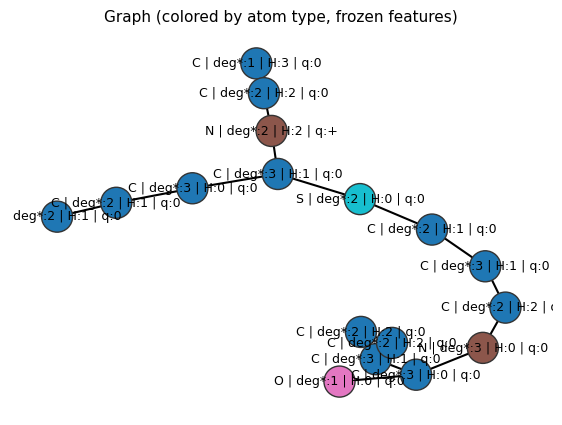

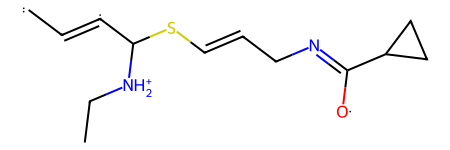

Num Atoms 17
Num Bonds 17
Is Induced subgraph:  False
Graph Nr: 1


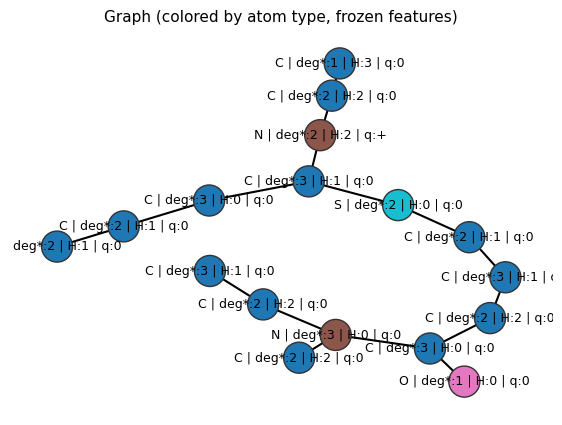

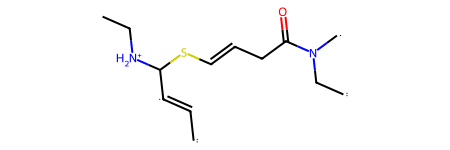

Num Atoms 17
Num Bonds 16
Is Induced subgraph:  False
Graph Nr: 2


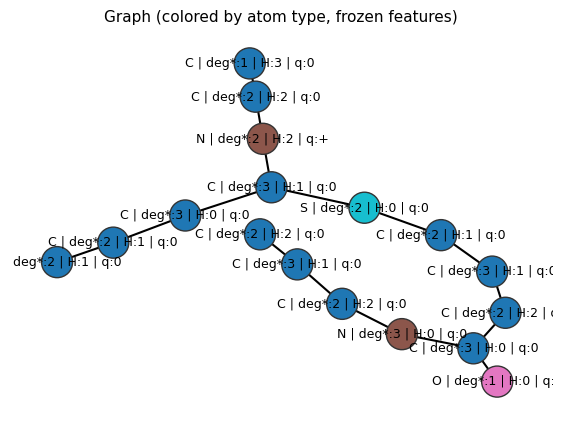

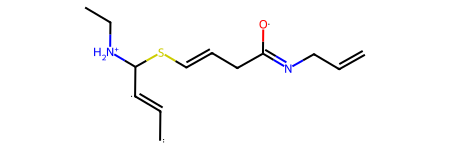

Num Atoms 17
Num Bonds 16
Is Induced subgraph:  False
Graph Nr: 3


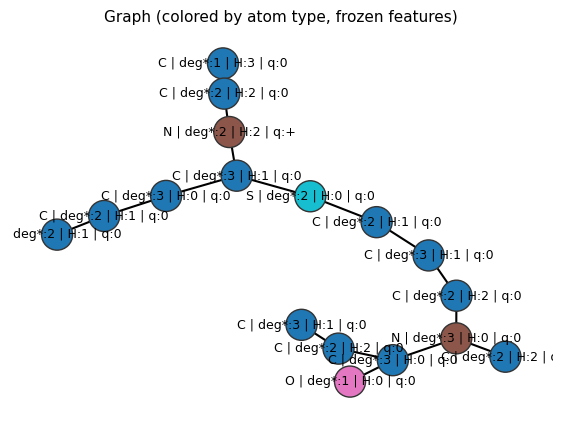

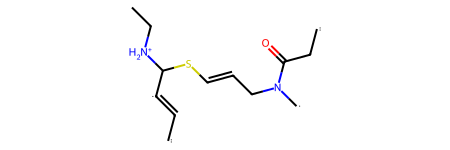

Num Atoms 17
Num Bonds 16
Is Induced subgraph:  False
Graph Nr: 4


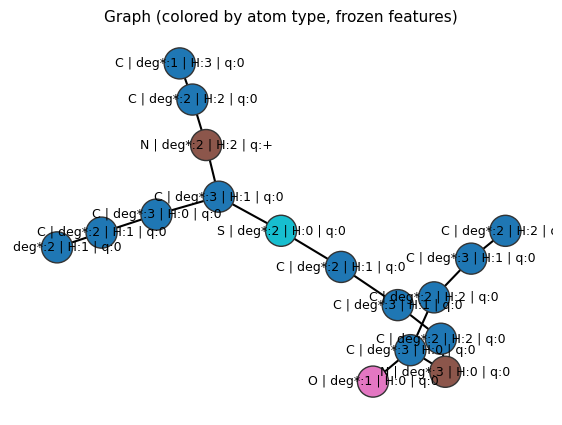

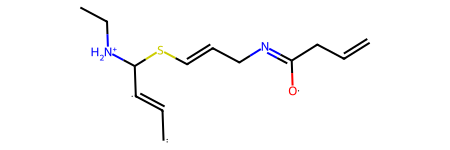

Num Atoms 17
Num Bonds 16
Is Induced subgraph:  False
Graph Nr: 5


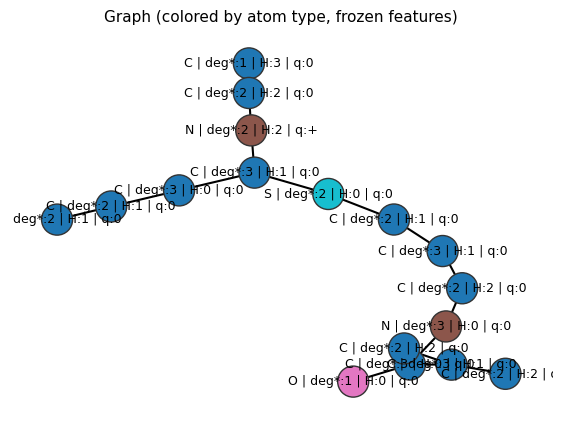

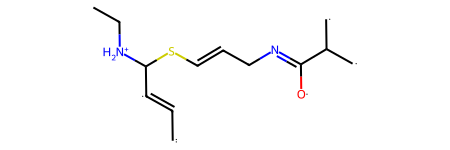

Num Atoms 17
Num Bonds 16
Is Induced subgraph:  False
Graph Nr: 6


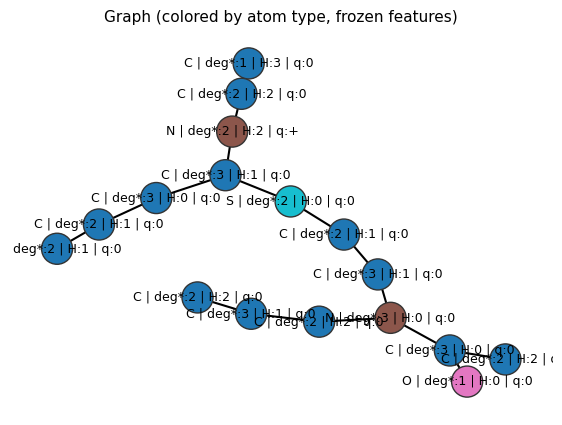

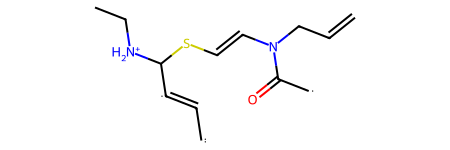

Num Atoms 17
Num Bonds 16
Is Induced subgraph:  False
Graph Nr: 7


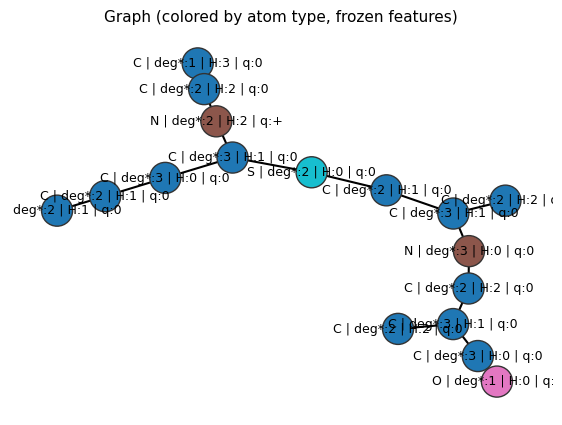

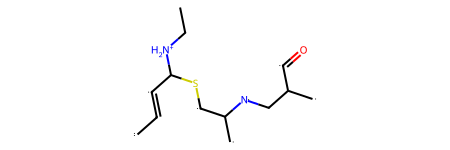

Num Atoms 17
Num Bonds 16
Is Induced subgraph:  False
Graph Nr: 8


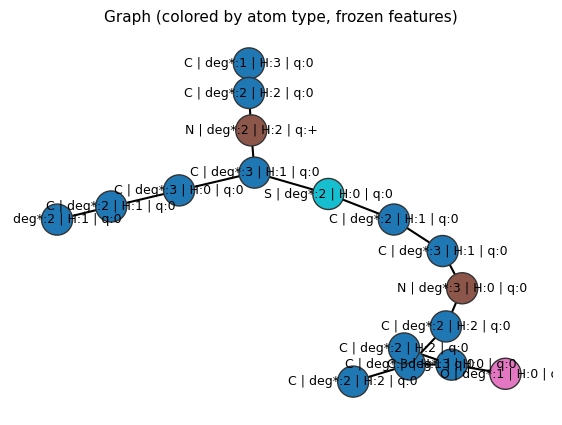

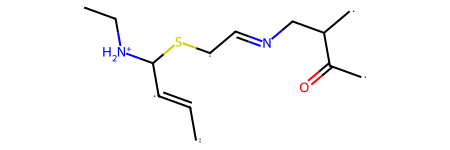

Num Atoms 17
Num Bonds 16
Is Induced subgraph:  False
Graph Nr: 9


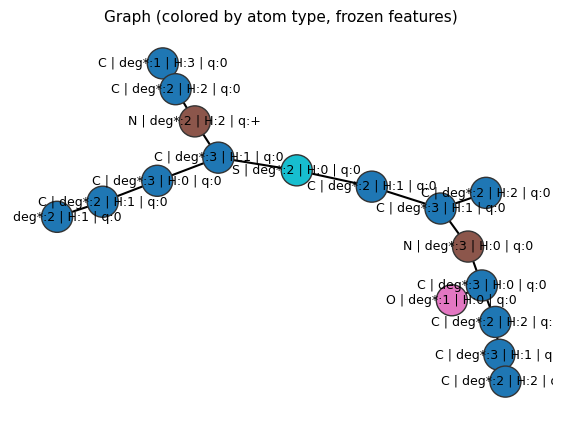

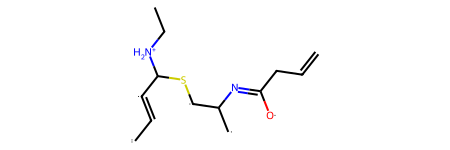

Num Atoms 17
Num Bonds 16
Is Induced subgraph:  False
Graph Nr: 10


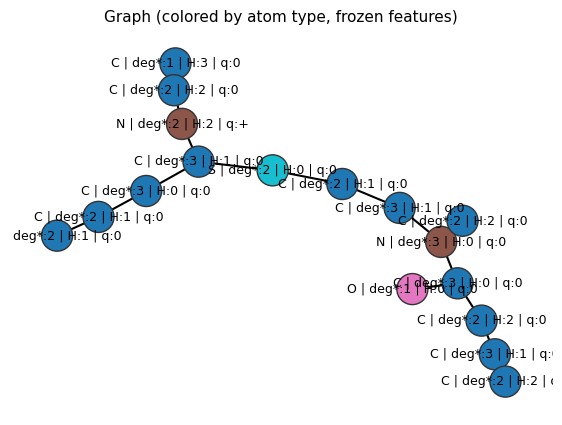

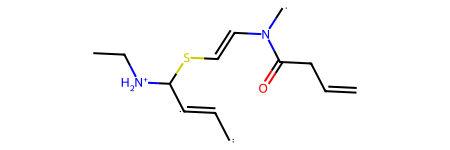

Num Atoms 17
Num Bonds 16
Is Induced subgraph:  False
[4] Original Graph


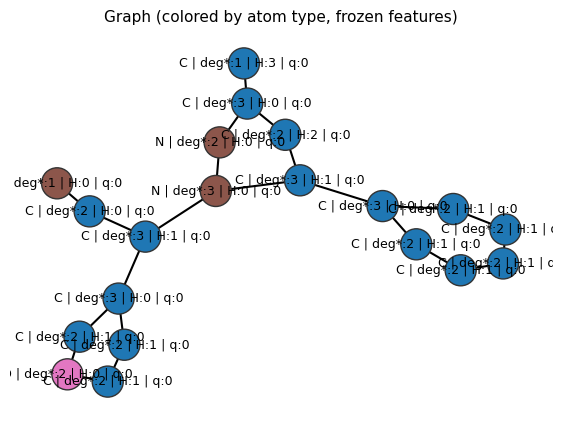

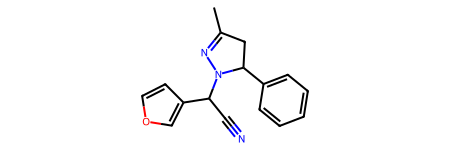

Num Nodes 20
Num Edges 22
Multiset Nodes 20
Decoding a graph with 20 nodes and 22 edges.
0
[]
[5] Original Graph


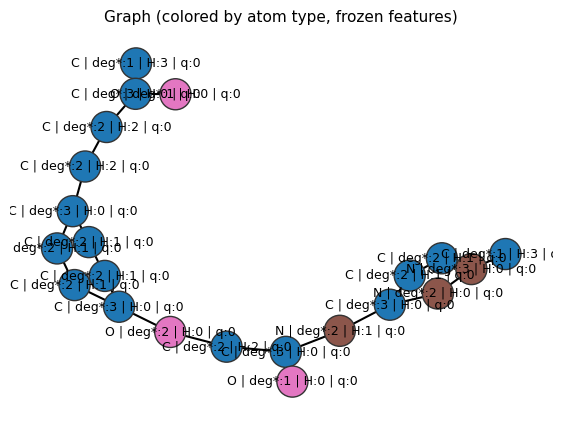

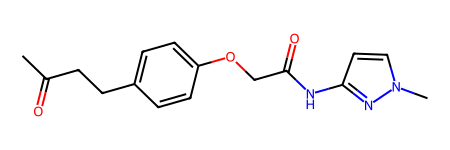

Num Nodes 22
Num Edges 23
Multiset Nodes 22
Decoding a graph with 22 nodes and 23 edges.
0
[]
[6] Original Graph


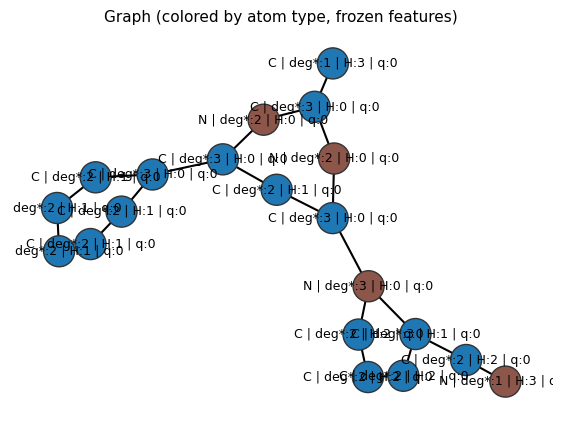

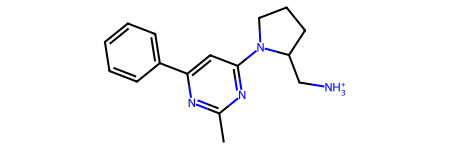

Num Nodes 20
Num Edges 22
Multiset Nodes 20
Decoding a graph with 20 nodes and 22 edges.
16
[<networkx.classes.graph.Graph object at 0x4f4baa840>, <networkx.classes.graph.Graph object at 0x4f4ba97f0>, <networkx.classes.graph.Graph object at 0x4f4baa570>, <networkx.classes.graph.Graph object at 0x4f4ba8830>, <networkx.classes.graph.Graph object at 0x4f4ba9be0>, <networkx.classes.graph.Graph object at 0x4f4bab2f0>, <networkx.classes.graph.Graph object at 0x4f4ba9490>, <networkx.classes.graph.Graph object at 0x4f4baaf00>, <networkx.classes.graph.Graph object at 0x4d1c83380>, <networkx.classes.graph.Graph object at 0x4f4babda0>, <networkx.classes.graph.Graph object at 0x4f4bab530>, <networkx.classes.graph.Graph object at 0x4f4babd10>, <networkx.classes.graph.Graph object at 0x4f4ba9130>, <networkx.classes.graph.Graph object at 0x4f4ba89e0>, <networkx.classes.graph.Graph object at 0x4f4ba8050>, <networkx.classes.graph.Graph object at 0x4f4ba84d0>]
Graph Nr: 0


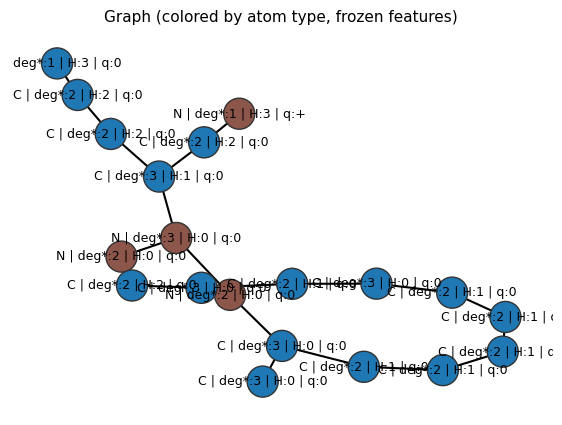

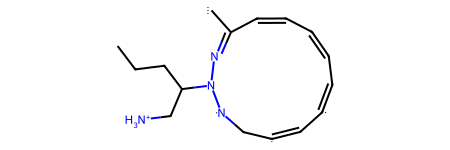

Num Atoms 20
Num Bonds 20
Is Induced subgraph:  False
Graph Nr: 1


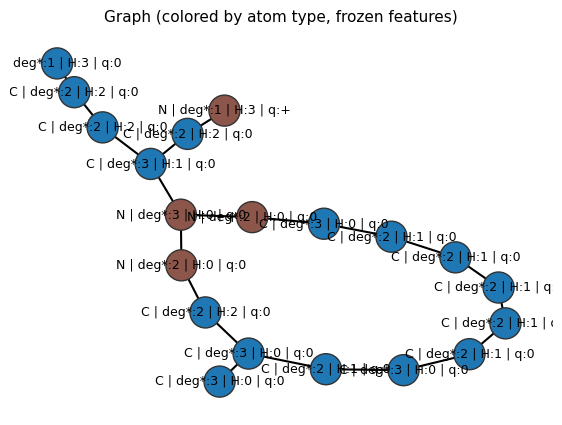

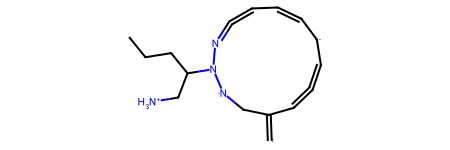

Num Atoms 20
Num Bonds 20
Is Induced subgraph:  False
Graph Nr: 2


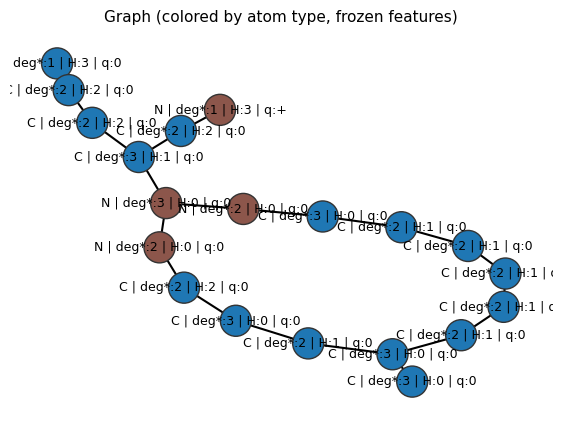

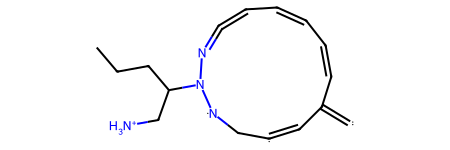

Num Atoms 20
Num Bonds 20
Is Induced subgraph:  False
Graph Nr: 3


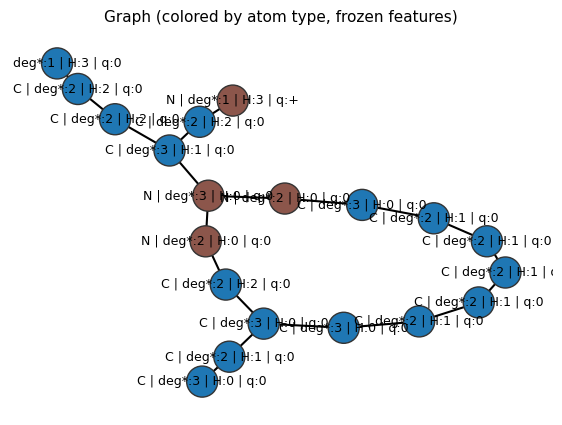

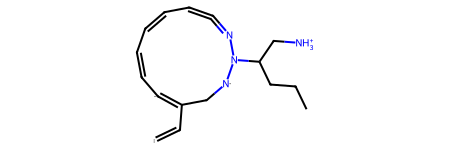

Num Atoms 20
Num Bonds 20
Is Induced subgraph:  False
Graph Nr: 4


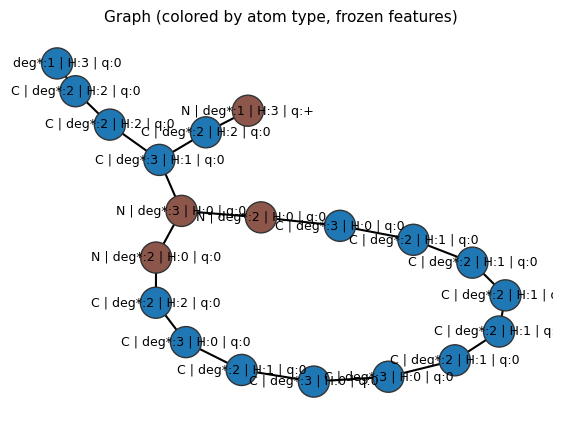

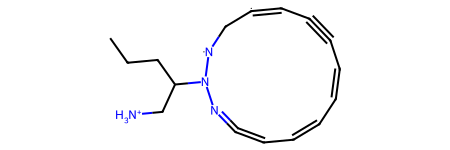

Num Atoms 20
Num Bonds 20
Is Induced subgraph:  False
Graph Nr: 5


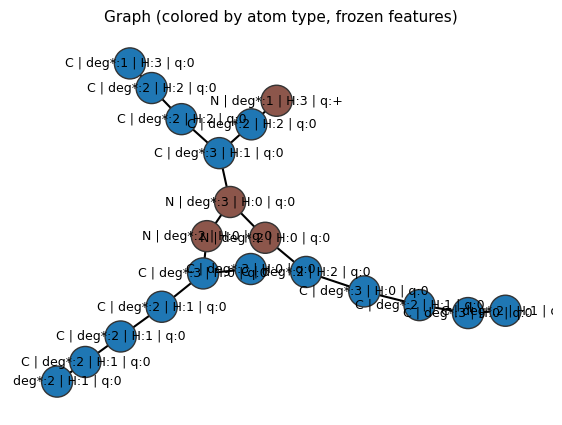

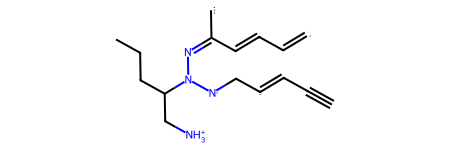

Num Atoms 20
Num Bonds 19
Is Induced subgraph:  False
Graph Nr: 6


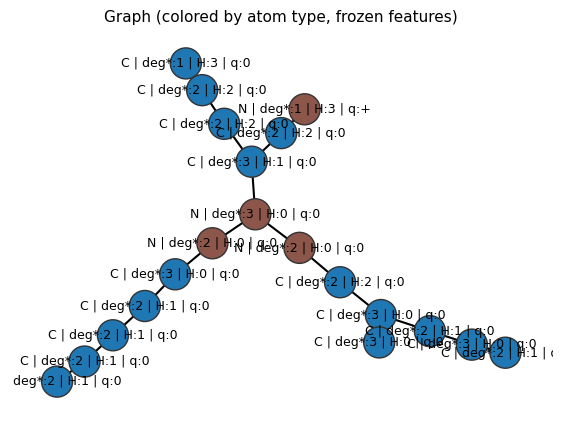

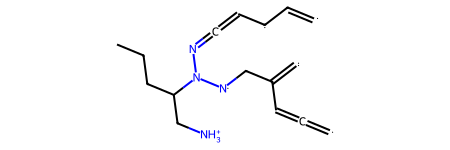

Num Atoms 20
Num Bonds 19
Is Induced subgraph:  False
Graph Nr: 7


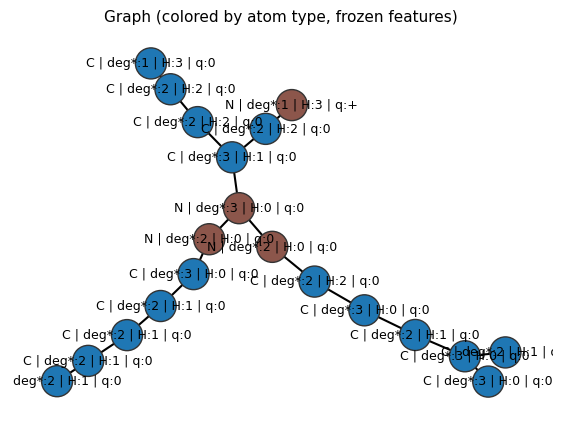

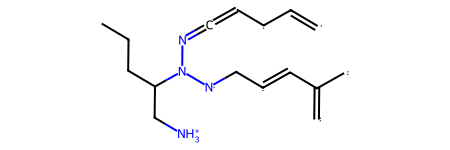

Num Atoms 20
Num Bonds 19
Is Induced subgraph:  False
Graph Nr: 8


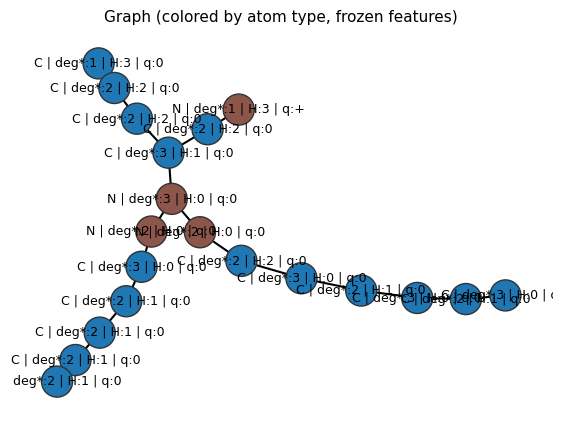

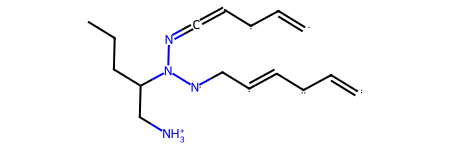

Num Atoms 20
Num Bonds 19
Is Induced subgraph:  False
Graph Nr: 9


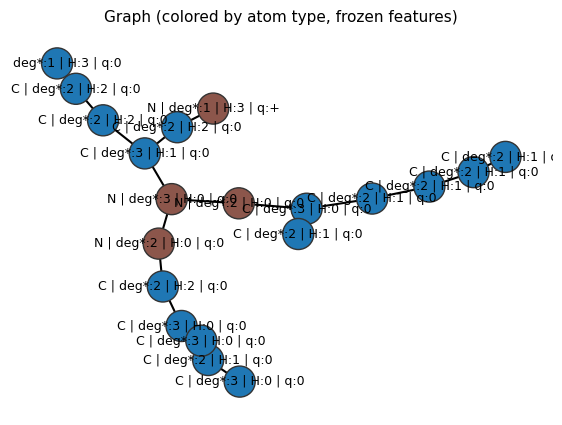

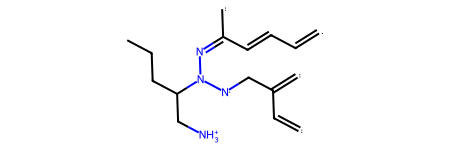

Num Atoms 20
Num Bonds 19
Is Induced subgraph:  False
Graph Nr: 10


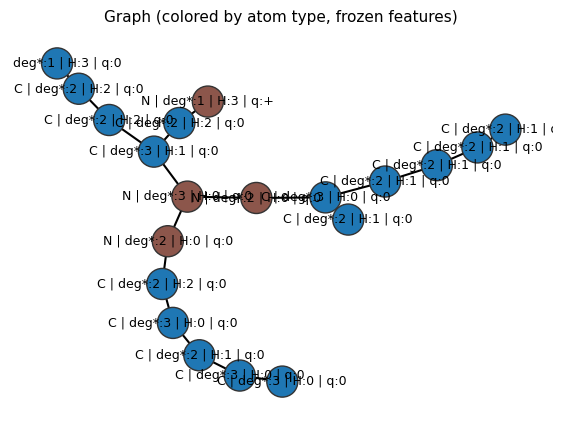

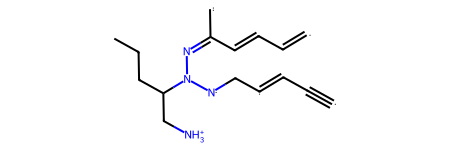

Num Atoms 20
Num Bonds 19
Is Induced subgraph:  False
Graph Nr: 11


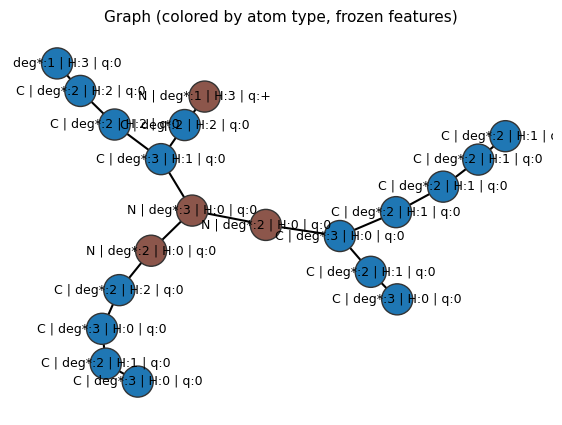

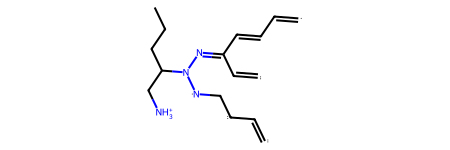

Num Atoms 20
Num Bonds 19
Is Induced subgraph:  False
Graph Nr: 12


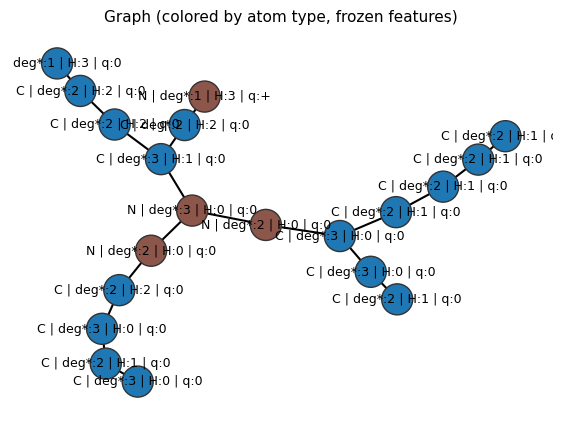

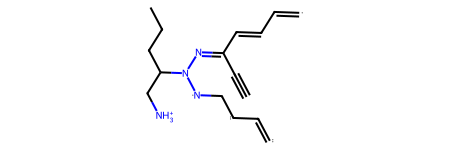

Num Atoms 20
Num Bonds 19
Is Induced subgraph:  False
Graph Nr: 13


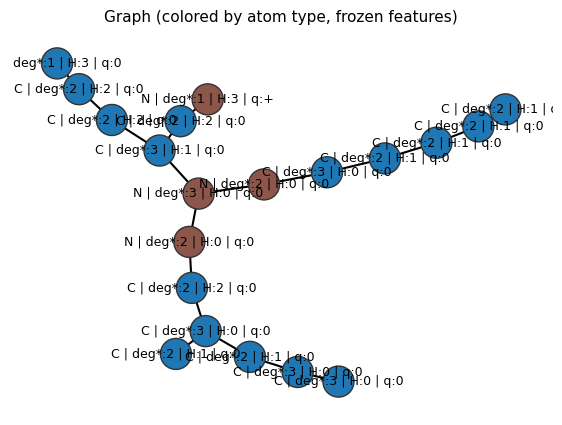

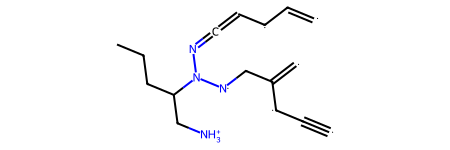

Num Atoms 20
Num Bonds 19
Is Induced subgraph:  False
Graph Nr: 14


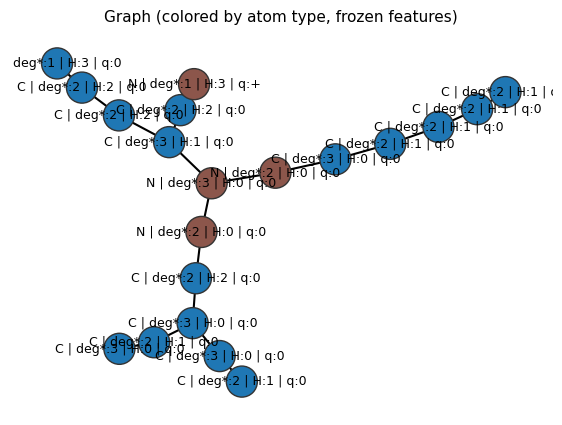

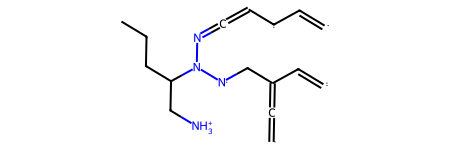

Num Atoms 20
Num Bonds 19
Is Induced subgraph:  False
Graph Nr: 15


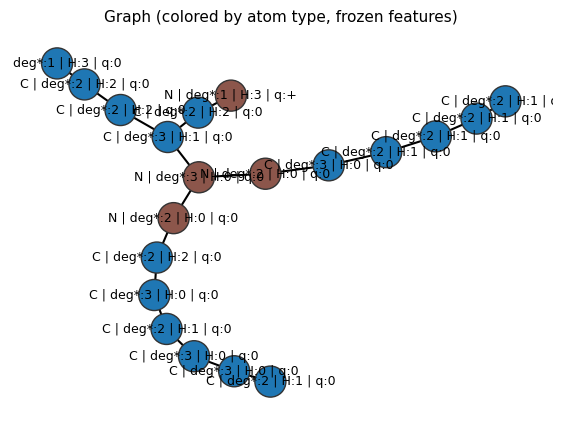

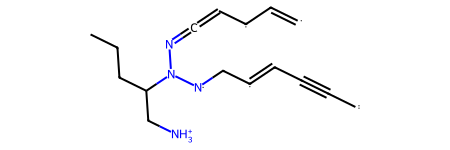

Num Atoms 20
Num Bonds 19
Is Induced subgraph:  False
[7] Original Graph


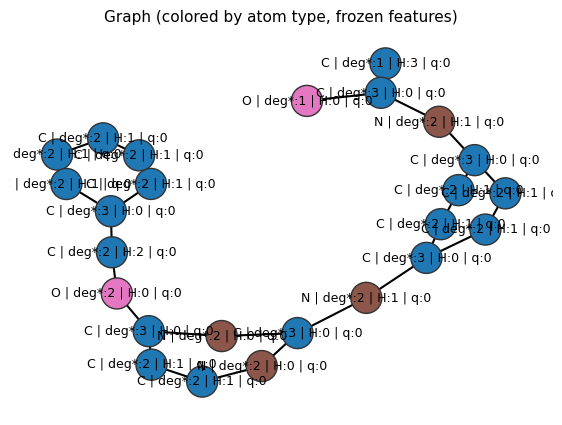

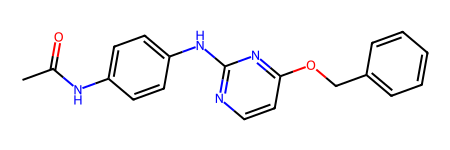

Num Nodes 25
Num Edges 27
Multiset Nodes 25
Decoding a graph with 25 nodes and 27 edges.
0
[]
[8] Original Graph


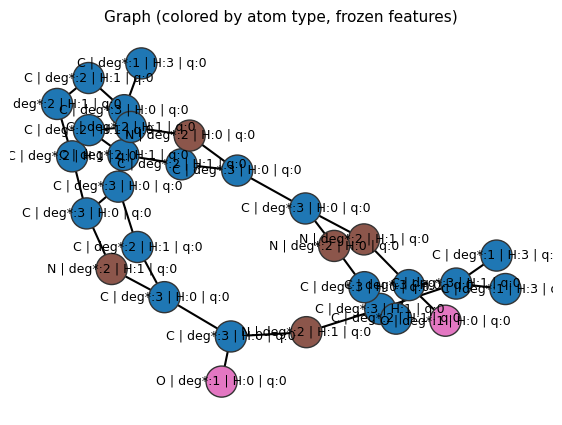

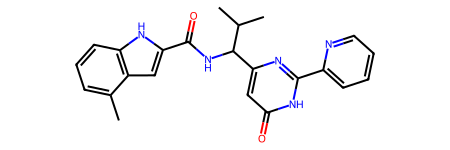

Num Nodes 30
Num Edges 33
Multiset Nodes 30
Decoding a graph with 30 nodes and 33 edges.
0
[]
[9] Original Graph


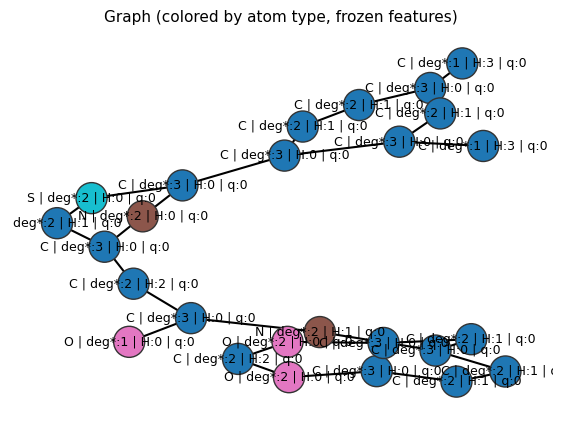

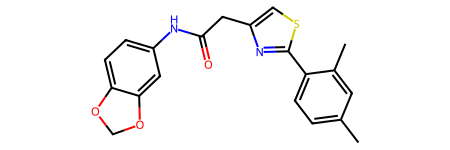

Num Nodes 26
Num Edges 29
Multiset Nodes 26
Decoding a graph with 26 nodes and 29 edges.
0
[]
[10] Original Graph


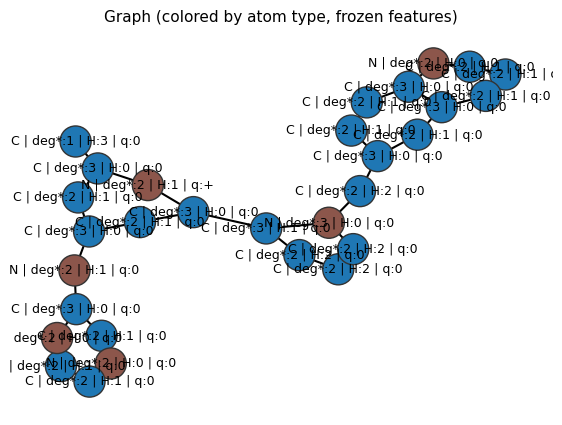

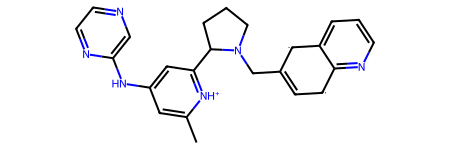

Num Nodes 30
Num Edges 34
Multiset Nodes 30
Decoding a graph with 30 nodes and 34 edges.
1
Graph Nr: 0


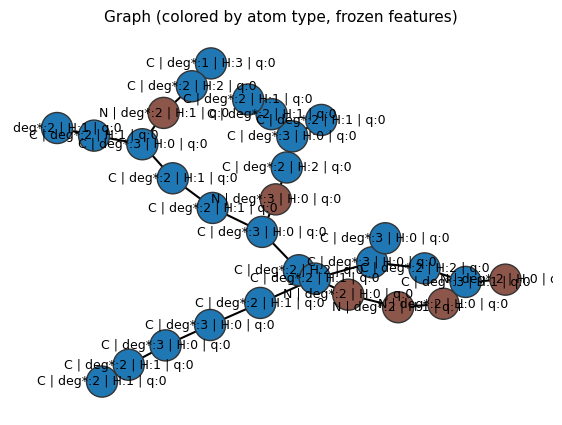

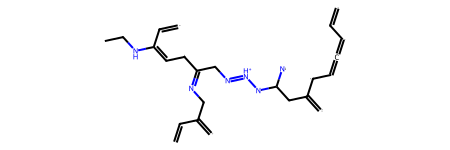

Num Atoms 30
Num Bonds 29
Is Induced subgraph:  False
[11] Original Graph


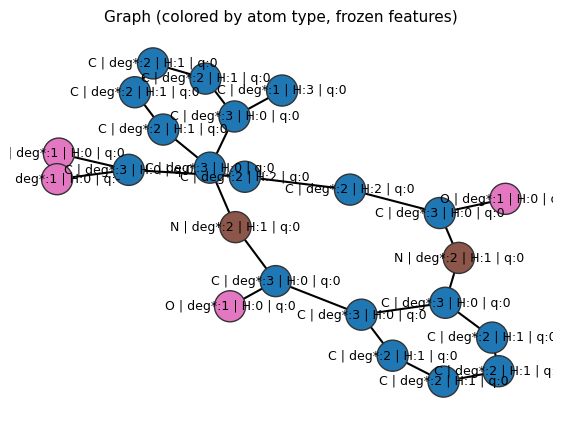

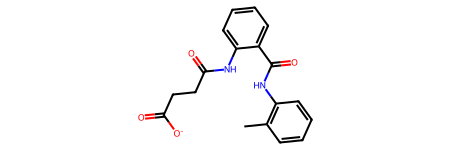

Num Nodes 24
Num Edges 25
Multiset Nodes 24
Decoding a graph with 24 nodes and 25 edges.
0
[]
[12] Original Graph


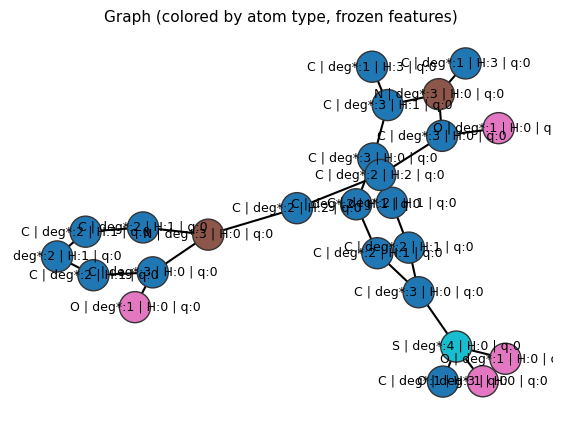

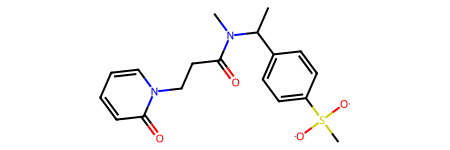

Num Nodes 25
Num Edges 26
Multiset Nodes 25
Decoding a graph with 25 nodes and 26 edges.
0
[]
[13] Original Graph


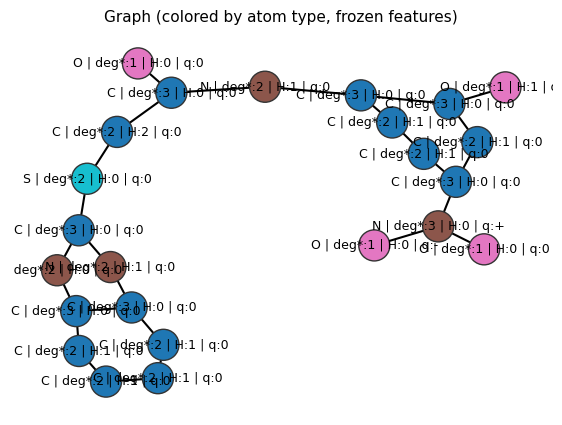

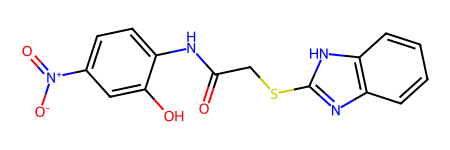

Num Nodes 24
Num Edges 26
Multiset Nodes 24
Decoding a graph with 24 nodes and 26 edges.
0
[]
[14] Original Graph


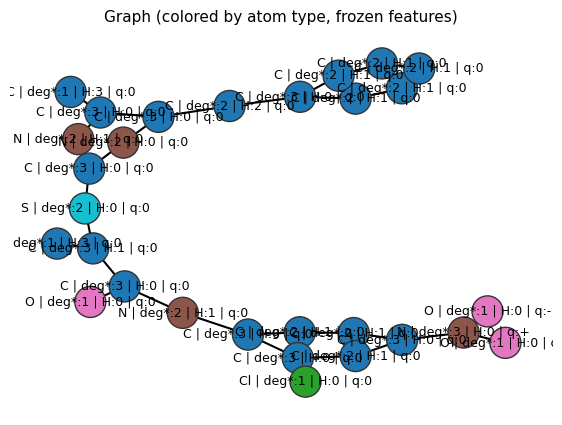

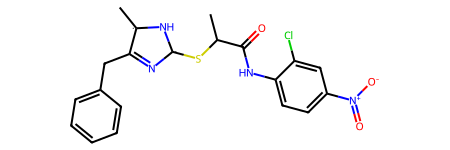

Num Nodes 29
Num Edges 31
Multiset Nodes 29
Decoding a graph with 29 nodes and 31 edges.
0
[]
[15] Original Graph


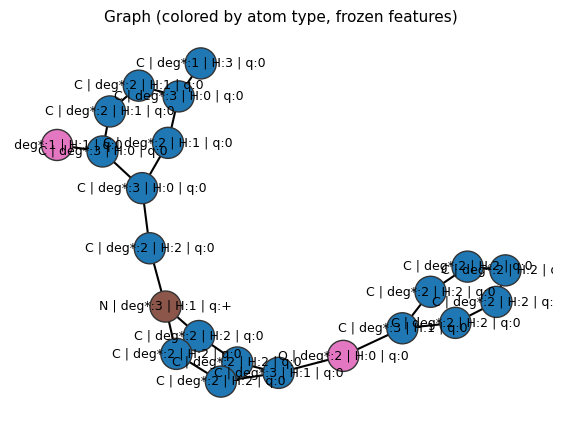

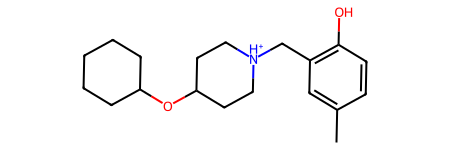

Num Nodes 22
Num Edges 24
Multiset Nodes 22
Decoding a graph with 22 nodes and 24 edges.


In [ ]:
from src.utils import visualisations
from src.encoding.decoder import greedy_oracle_decoder
from pathlib import Path
from src.encoding.oracles import MLPClassifier, Oracle
from pprint import pprint
from src.utils.utils import DataTransformer
from torchhd import HRRTensor


# Real Oracle
def is_induced_subgraph_feature_aware(G_small: nx.Graph, G_big: nx.Graph) -> bool:
    """NetworkX VF2: is `G_small` an induced, label-preserving subgraph of `G_big`?"""
    nm = lambda a, b: a["feat"] == b["feat"]
    GM = nx.algorithms.isomorphism.GraphMatcher(G_big, G_small, node_match=nm)
    return GM.subgraph_is_isomorphic()


batch_size = 64
zinc_smiles = ZincSmiles(split="valid")[:batch_size]
dataloader = DataLoader(dataset=zinc_smiles, batch_size=batch_size, shuffle=False)

# Classifier
chkpt = torch.load(Path("/Users/akaveh/projects/kit/graph_hdc/_models/mlp_stratified_base_laynorm_2nd_try.pt"), map_location="cpu",
                   weights_only=False)

cfg = chkpt["config"]
# print(f"Classifier's best metric (AUC): {chkpt['best_metric']}")
print(f"Classifier's cfg")
pprint(cfg, indent=4)

classifier = MLPClassifier(
    hv_dim=cfg.get("hv_dim"),
    hidden_dims=cfg.get("hidden_dims"),
    use_layer_norm=cfg.get("use_layer_norm"),
    use_batch_norm=cfg.get("use_batch_norm")).to(device).eval()
classifier.load_state_dict(chkpt["model_state"], strict=True)
oracle = Oracle(model=classifier)
oracle.encoder = hypernet

y = []
for batch in dataloader:
    # Encode the whole graph in one HV
    encoded_data = hypernet.forward(batch)
    node_term = encoded_data["node_terms"]
    graph_term = encoded_data["graph_embedding"]

    graph_terms_hd = graph_term.as_subclass(HRRTensor)

    ground_truth_counters = {}
    datas = batch.to_data_list()
    for j, g in enumerate(range(batch_size)):
        print("================================================")
        full_graph_nx = DataTransformer.pyg_to_nx(data=datas[g])
        print(f"[{j}] Original Graph")
        visualisations.draw_nx_with_atom_colorings(full_graph_nx)
        plt.show()
        mol_full, _ = DataTransformer.nx_to_mol(full_graph_nx)
        display(mol_full)

        print(f"Num Nodes {datas[g].num_nodes}")
        print(f"Num Edges {int(datas[g].num_edges / 2)}")
        node_multiset = DataTransformer.get_node_counter_from_batch(batch=g, data=batch)
        print(f"Multiset Nodes {node_multiset.total()}")
        nx_GS: list[nx.Graph] = greedy_oracle_decoder(node_multiset=node_multiset, oracle=oracle, full_g_h=graph_terms_hd[g],
                                                beam_size=16, oracle_threshold=0.764)
        print(len(nx_GS))
        print(nx_GS)
        nx_GS = list(filter(None, nx_GS))
        for i, g in enumerate(nx_GS):
            print(f"Graph Nr: {i}")
            visualisations.draw_nx_with_atom_colorings(g)
            plt.show()

            mol, _ = DataTransformer.nx_to_mol(g)
            display(mol)
            print(f"Num Atoms {mol.GetNumAtoms()}")
            print(f"Num Bonds {mol.GetNumBonds()}")

            is_induced = is_induced_subgraph_feature_aware(g, full_graph_nx)
            print("Is Induced subgraph: ", is_induced)
            y.append(int(is_induced))

print(f"Accuracy: {sum(y) / len(y)}")